# Rescheduling mit Lateness (Max)
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [1]:
from configs.config import get_path
import src.utils.converter as convert
import src.utils.presenter as show
import src.utils.checker as check

import math
import pulp
import pandas as pd
pd.set_option('display.max_rows', 21)

import src.utils.gen_jobs as gen_jobs
import src.utils.gen_deadline as gen_deadline
import src.utils.rolling_scheduling as rolling_schedule

import src.models.heuristics.fcfs as heuristics
import src.models.lp.lateness_solver as solver
from src.simulation.ProductionDaySimulation import ProductionDaySimulation
import time

In [1]:
max_time = 60*60*4 # 4h
max_time = 60*45 # 45 min

In [5]:
basic_data_path = get_path("data", "basic")

df_instance = pd.read_csv(basic_data_path / "00_instance.csv")
df_jssp, df_jobs_arrivals = gen_jobs.create_jobs_for_days(df_instance, day_count = 1, u_b_mmax= 0.92, shuffle = True)
df_jobs_arrivals

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [6]:
df_jobs = gen_deadline.get_times_df(df_jssp, df_jobs_arrivals, heuristics.schedule_fcfs_with_arrivals, target_service=1.0)
df_jobs

,Job,Operation,Machine,Processing Time
0,Job_000,0,M0,29
1,Job_000,1,M1,78
2,Job_000,2,M2,9
3,Job_000,3,M3,36
4,Job_000,4,M4,49
...,...,...,...,...
375,Job_037,5,M9,76
376,Job_037,6,M5,47
377,Job_037,7,M3,52
378,Job_037,8,M4,90


## I) Complete Scheduling

In [9]:
starting_time = time.time()

# Scheduling
df_plan = solver.solve_jssp_max_absolute_lateness(df_jssp, df_jobs, solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.05)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan

BigM: 23000

Solver-Informationen:
  Summe Flow Times        : 32601.22
  Solver-Status           : Optimal
  Anzahl Variablen        : 7448
  Anzahl Constraints      : 14440

Scheduling-Dauer: 180 Minuten und 0.29 Sekunden.


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0,0.00,M0,0.00,29.0,29.00,29.00
1,Job_000,1,0.00,M1,29.00,78.0,107.00,107.00
2,Job_001,0,88.05,M0,88.05,43.0,43.00,131.05
3,Job_000,2,0.00,M2,107.00,9.0,116.00,116.00
4,Job_000,3,0.00,M3,116.00,36.0,152.00,152.00
...,...,...,...,...,...,...,...,...
375,Job_037,5,2869.61,M9,3880.95,76.0,1087.34,3956.95
376,Job_037,6,2869.61,M5,3956.95,47.0,1134.34,4003.95
377,Job_037,7,2869.61,M3,4003.95,52.0,1186.34,4055.95
378,Job_037,8,2869.61,M4,4055.95,90.0,1276.34,4145.95


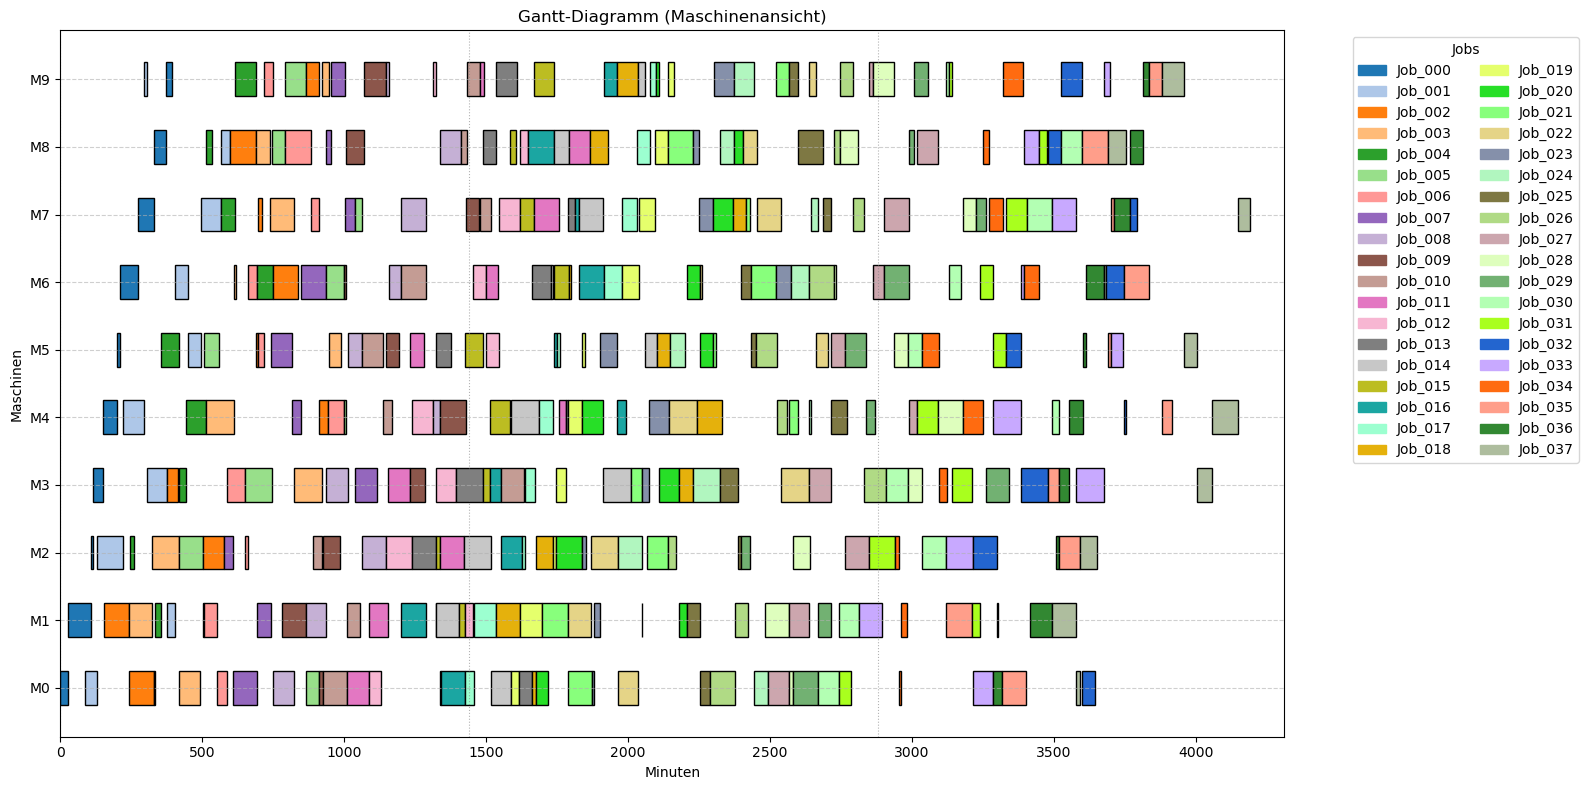

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [10]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

## II) Erster Tag (Tag 0)

### a) Simulation

In [11]:
day_length = 1440

In [12]:
day_numb = 0

day_start = day_length*day_numb 
day_end = day_start + day_length

In [13]:
simulation = ProductionDaySimulation(df_plan, vc=0.25)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[00:00:00] Job_000 started on M0
[00:13:11] Job_000 finished on M0 (after 13 minutes 12 seconds)
[00:29:00] Job_000 started on M1
[01:24:39] Job_000 finished on M1 (after 55 minutes 39 seconds)
[01:28:02] Job_001 started on M0
[01:47:00] Job_000 started on M2
[01:59:22] Job_000 finished on M2 (after 12 minutes 22 seconds)
[01:59:22] Job_000 started on M3
[02:03:22] Job_001 finished on M0 (after 35 minutes 20 seconds)
[02:11:03] Job_001 started on M2
[02:32:46] Job_002 started on M1
[02:52:55] Job_000 finished on M3 (after 53 minutes 33 seconds)
[02:52:55] Job_000 started on M4
[03:29:15] Job_001 finished on M2 (after 78 minutes 13 seconds)
[03:56:35] Job_000 finished on M4 (after 63 minutes 40 seconds)
[03:56:35] Job_001 started on M4
[03:56:35] Job_000 started on M5
[04:05:03] Job_000 finished on M5 (after 08 minutes 28 seconds)
[04:05:03] Job_000 started on M6
[04:06:36] Job_004 started on M2
[04:10:01] Job_002 finished on M1 (after 97 minutes 14 seconds)
[04:10:01] Job_003 started o

In [14]:
df_undone

,Job,Operation,Arrival,Machine,Planned Start,Processing Time
0,Job_008,6,748.04,M6,1158.95,40.0
1,Job_008,7,748.04,M7,1198.95,89.0
2,Job_008,8,748.04,M4,1312.95,26.0
3,Job_013,1,1185.73,M1,1321.95,2.0
4,Job_015,0,1197.28,M2,1321.95,14.0
...,...,...,...,...,...,...
259,Job_037,5,2869.61,M9,3880.95,76.0
260,Job_037,6,2869.61,M5,3956.95,47.0
261,Job_037,7,2869.61,M3,4003.95,52.0
262,Job_037,8,2869.61,M4,4055.95,90.0


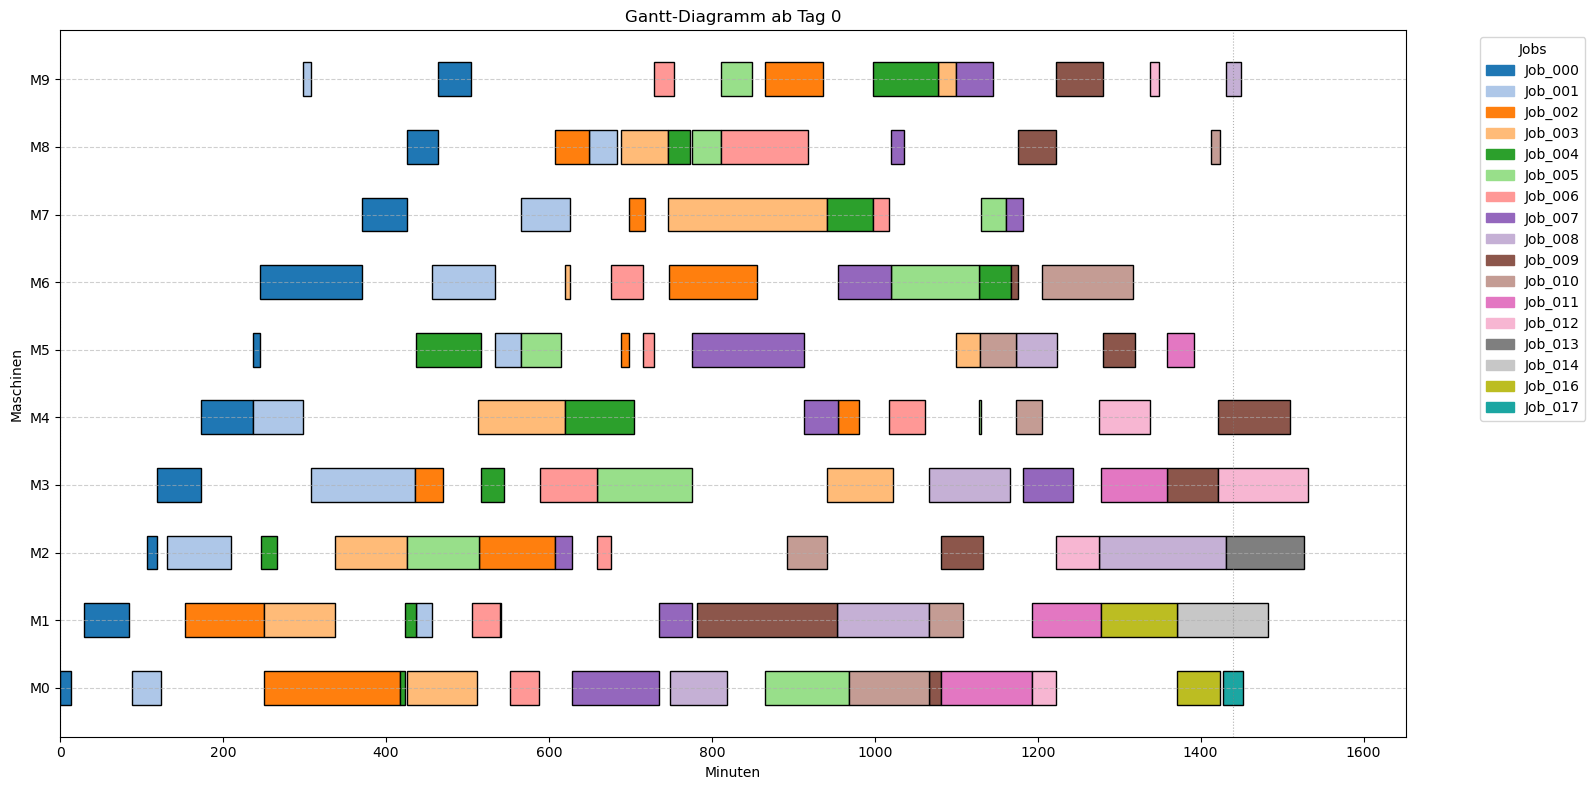

In [15]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

### b) Verbleibene Jobs (Rest)

In [16]:
df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_008,6,748.04,M6,1158.95,40.0,450.91,1198.95
1,Job_008,7,748.04,M7,1198.95,89.0,539.91,1287.95
2,Job_008,8,748.04,M4,1312.95,26.0,590.91,1338.95
3,Job_008,9,748.04,M8,1338.95,74.0,664.91,1412.95
4,Job_009,9,781.95,M7,1428.95,45.0,692.00,1473.95
...,...,...,...,...,...,...,...,...
259,Job_037,5,2869.61,M9,3880.95,76.0,1087.34,3956.95
260,Job_037,6,2869.61,M5,3956.95,47.0,1134.34,4003.95
261,Job_037,7,2869.61,M3,4003.95,52.0,1186.34,4055.95
262,Job_037,8,2869.61,M4,4055.95,90.0,1276.34,4145.95


In [17]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_jobs[df_jobs["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival
8,Job_008,748.04
9,Job_009,781.95
10,Job_010,891.94
11,Job_011,944.71
12,Job_012,1003.56
...,...,...
33,Job_033,2630.89
34,Job_034,2637.28
35,Job_035,2638.72
36,Job_036,2764.04


## III) Rescheduling
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [18]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 1440]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
85,Job_008,5,748.04,M9,1431.11,17.99,701.06,1449.10
94,Job_009,8,781.95,M4,1421.32,88.51,727.88,1509.83
110,Job_012,4,1003.56,M3,1421.32,110.87,528.63,1532.19
111,Job_013,0,1185.73,M2,1431.11,95.71,341.09,1526.82
112,Job_014,0,1190.89,M1,1371.26,111.74,292.11,1483.00
115,Job_017,0,1324.04,M0,1426.95,24.51,127.42,1451.46


In [19]:
starting_time = time.time()
df_reschedule = solver.solve_jssp_max_lateness_with_fixed_ops(df_rest, df_time_rest, df_execution_important,
                                                                   reschedule_start = 1440,
                                                                   solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.10)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_reschedule

BigM: 16000

Solver-Informationen:
  Summe Flow Times        : 29516.87
  Solver-Status           : Optimal
  Anzahl Variablen        : 3818
  Anzahl Constraints      : 7342


,Job,Operation,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_008,6,748.04,M6,1449.10,40.0,741.06,1489.10
1,Job_010,7,891.94,M9,1449.10,48.0,605.16,1497.10
2,Job_019,0,1440.00,M0,1451.46,29.0,40.46,1480.46
3,Job_010,8,891.94,M7,1497.10,36.0,641.16,1533.10
4,Job_013,1,1185.73,M1,1526.82,2.0,343.09,1528.82
...,...,...,...,...,...,...,...,...
259,Job_033,8,2630.89,M9,3769.19,22.0,1160.30,3791.19
260,Job_033,9,2630.89,M5,3791.19,43.0,1203.30,3834.19
261,Job_037,7,2869.61,M3,3791.19,52.0,973.58,3843.19
262,Job_037,8,2869.61,M4,3843.19,90.0,1063.58,3933.19


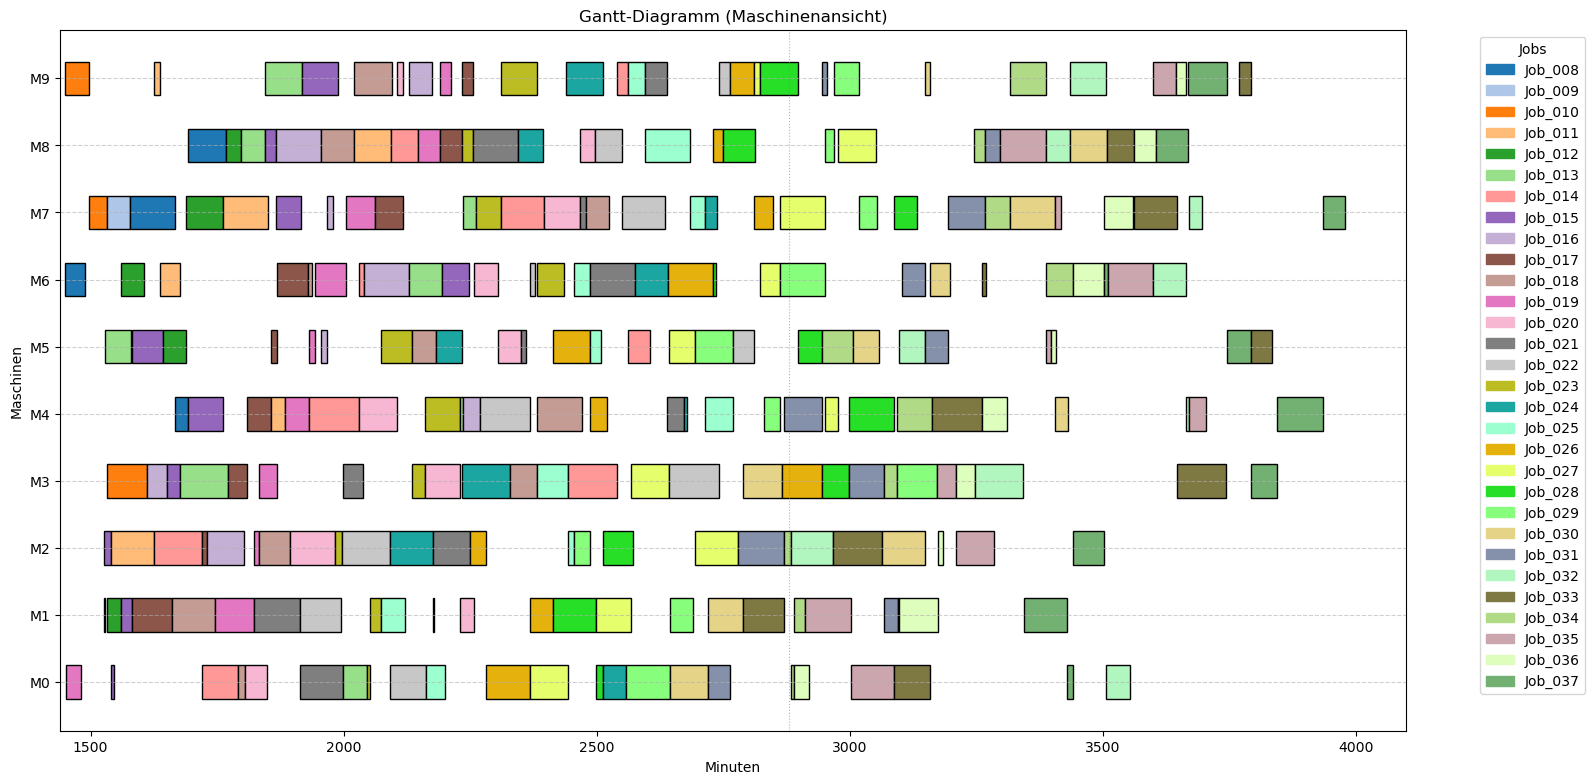

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job


True

In [20]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)